# **Import librares**

In [2]:
!pip install Keras-Preprocessing
import numpy as np
import pandas as pd
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.corpus import reuters
from nltk.corpus import brown
from nltk.corpus import gutenberg
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pickle
import joblib
from collections import Counter
from textblob import Word 
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import KFold 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, f1_score, recall_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras_preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Activation, Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Flatten, GRU, Conv1D, MaxPooling1D, Bidirectional
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import urllib
import requests
from keras.regularizers import l2
!pip install ktrain
import ktrain
from ktrain import text
sns.set()
%matplotlib inline
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('gutenberg')
nltk.download('brown')
nltk.download("reuters")
nltk.download('words')

ModuleNotFoundError: No module named 'textblob'

### **Load Dataset**

In [3]:
df=pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Dataset/Final_Twitter_Suicide_Dataset.csv", engine='python', encoding='UTF-8')
df=df.replace('Potential Suicide post ','Potential Suicide post')
df

,Tweet,Suicide
0,You guys would be better off without me anyways,Potential Suicide post
1,ah.... 90's pop was so good,Not Suicide post
2,Unfortunately I canât leave well enough alon...,Potential Suicide post
3,is a bit happier. She found her Chanel sunglas...,Not Suicide post
4,"If death came knocking at my door right now, I...",Potential Suicide post
...,...,...
2431,Positive Thinking: Find Happiness And Achieve ...,Not Suicide post
2432,"@mcherrywv pleasant is right thank u V8 ppl, u...",Not Suicide post
2433,May you live every day of your life: Jonathan ...,Not Suicide post
2434,seems like instead of me hoping i ll live past...,Potential Suicide post


# **Data Cleaning**

In [4]:
df['Tweet']=df['Tweet'].fillna("") 
df.isna().sum()

Tweet      0
Suicide    0
dtype: int64

# **Preprocessing**

In [ ]:
#Convert to lower case
df['lower_case']= df['Tweet'].apply(lambda x: x.lower())   
#Tokenize
tokenizer = RegexpTokenizer(r'\w+')
df['Special_word'] = df.apply(lambda row: tokenizer.tokenize(row['lower_case']), axis=1)  
#Stop words remove
stop = stopwords.words('english')
stop.remove("not")
stop.remove("here")
stop.remove("some")
df['stop_words'] = df['Special_word'].apply(lambda x: [item for item in x if item not in stop])
df['stop_words'] = df['stop_words'].astype('str')
#Filter words based on length
df['short_word'] = df['stop_words'].str.findall('\w{3,}')
df['string']=df['short_word'].str.join(' ') 
#Removing non-english words(mention,emoji,link,special characters etc..)
words = set(nltk.corpus.words.words())
for w in reuters.words():
  words.add(w)
for w in brown.words():
  words.add(w)
for w in gutenberg.words():
  words.add(w)
df['NonEnglish'] = df['string'].apply(lambda x: " ".join(x for x in x.split() if x in words))  
#Lemmatization
df['tweet'] = df['NonEnglish'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) 

In [ ]:
df.head(5)

,Tweet,Suicide,lower_case,Special_word,stop_words,short_word,string,NonEnglish,tweet
0,You guys would be better off without me anyways,Potential Suicide post,you guys would be better off without me anyways,"[you, guys, would, be, better, off, without, m...","['guys', 'would', 'better', 'without', 'anyways']","[guys, would, better, without, anyways]",guys would better without anyways,guys would better without anyways,guy would better without anyways
1,ah.... 90's pop was so good,Not Suicide post,ah.... 90's pop was so good,"[ah, 90, s, pop, was, so, good]","['ah', '90', 'pop', 'good']","[pop, good]",pop good,pop good,pop good
2,Unfortunately I canât leave well enough alon...,Potential Suicide post,unfortunately i canât leave well enough alon...,"[unfortunately, i, canâ, t, leave, well, enoug...","['unfortunately', 'canâ', 'leave', 'well', 'en...","[unfortunately, canâ, leave, well, enough, alo...",unfortunately canâ leave well enough alone try...,unfortunately leave well enough alone,unfortunately leave well enough alone
3,is a bit happier. She found her Chanel sunglas...,Not Suicide post,is a bit happier. she found her chanel sunglas...,"[is, a, bit, happier, she, found, her, chanel,...","['bit', 'happier', 'found', 'chanel', 'sunglas...","[bit, happier, found, chanel, sunglasses]",bit happier found chanel sunglasses,bit happier found,bit happier found
4,"If death came knocking at my door right now, I...",Potential Suicide post,"if death came knocking at my door right now, i...","[if, death, came, knocking, at, my, door, righ...","['death', 'came', 'knocking', 'door', 'right',...","[death, came, knocking, door, right, hesitate,...",death came knocking door right hesitate answer,death came knocking door right hesitate answer,death came knocking door right hesitate answer


## Visualization

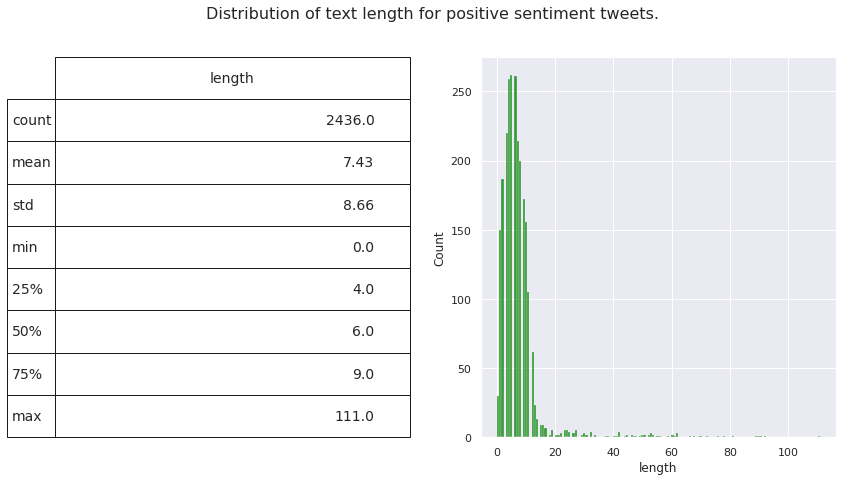

In [ ]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.tweet.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df['length'], ax=ax1,color='green')
describe = df.length.describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment tweets.', fontsize=16)

plt.show()

<AxesSubplot:xlabel='Suicide', ylabel='count'>

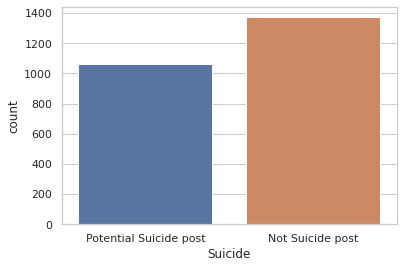

In [ ]:
sns.set_theme(style="whitegrid")
sns.countplot(x=df["Suicide"])

In [ ]:
top = Counter([item for sublist in df['short_word'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [ ]:
Not_Suicide_post = df[df['Suicide']=='Not Suicide post']
Potential_Suicide_post = df[df['Suicide']=='Potential Suicide post'] 

In [ ]:
top = Counter([item for sublist in Not_Suicide_post['short_word'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
fig = px.bar(temp_positive, x="count", y="Common_words", title='Most Commmon Words in Not_Suicide_Post', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [ ]:
top = Counter([item for sublist in Potential_Suicide_post['short_word'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
fig = px.bar(temp_positive, x="count", y="Common_words", title='Most Commmon Words in Potential_Suicide_post', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

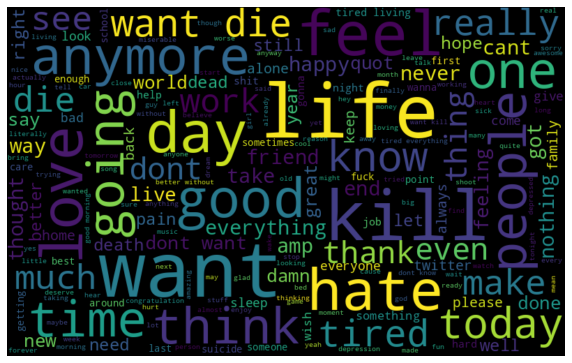

In [ ]:
normal_words =' '.join([text for text in df['tweet']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

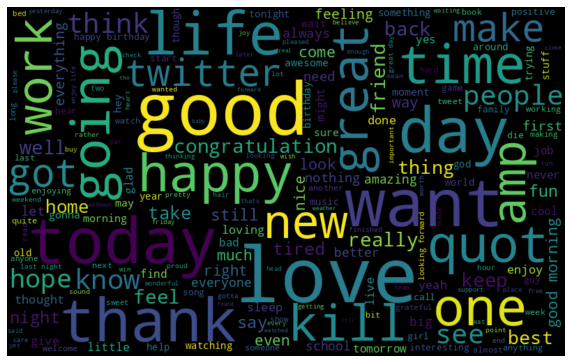

In [ ]:
normal_words =' '.join([text for text in df['tweet'][df['Suicide'] == 'Not Suicide post']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

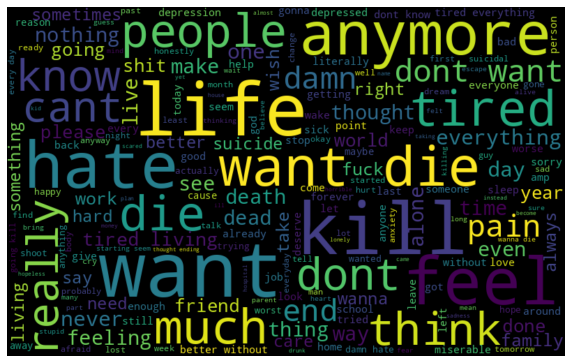

In [ ]:
normal_words =' '.join([text for text in df['tweet'][df['Suicide'] == 'Potential Suicide post']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## **Applying N-gram**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df["tweet"],df["Suicide"], test_size = 0.25, random_state = 42)    
count_vect = CountVectorizer(ngram_range=(1, 2))        
transformer = TfidfTransformer(norm='l2',sublinear_tf=True)

x_train_counts = count_vect.fit_transform(x_train)
x_train_tfidf = transformer.fit_transform(x_train_counts)

x_test_counts = count_vect.transform(x_test)
x_test_tfidf = transformer.transform(x_test_counts)

print (x_train_tfidf.shape,x_test_tfidf.shape, y_train.shape, y_test.shape)

(1827, 12629) (609, 12629) (1827,) (609,)


# **Machine Learning Models**

# **Logistic Regression**

In [ ]:
lr = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
lr.fit(x_train_tfidf, y_train)
y_pred1 = lr.predict(x_test_tfidf)
print("Accuracy: "+str(accuracy_score(y_test,y_pred1)))
print(classification_report(y_test, y_pred1))

Accuracy: 0.90311986863711
                        precision    recall  f1-score   support

      Not Suicide post       0.90      0.93      0.91       334
Potential Suicide post       0.91      0.88      0.89       275

              accuracy                           0.90       609
             macro avg       0.90      0.90      0.90       609
          weighted avg       0.90      0.90      0.90       609



In [ ]:
scores = cross_val_score(lr, x_train_tfidf,y_train, cv=5)  
print(accuracy_score(y_test,y_pred1))
print ("Cross-validated scores:", scores)

0.90311986863711
Cross-validated scores: [0.84699454 0.84699454 0.87945205 0.84657534 0.84383562]


# **Support Vector Machine**

In [ ]:
svc = LinearSVC()
svc.fit(x_train_tfidf, y_train)
y_pred2 = svc.predict(x_test_tfidf)
print("Accuracy: "+str(accuracy_score(y_test,y_pred2)))
print(classification_report(y_test, y_pred2))

Accuracy: 0.9146141215106732
                        precision    recall  f1-score   support

      Not Suicide post       0.92      0.92      0.92       334
Potential Suicide post       0.91      0.91      0.91       275

              accuracy                           0.91       609
             macro avg       0.91      0.91      0.91       609
          weighted avg       0.91      0.91      0.91       609



In [ ]:
scores = cross_val_score(svc, x_train_tfidf,y_train, cv=5)   
print(accuracy_score(y_test,y_pred2))
print ("Cross-validated scores:", scores)

0.9146141215106732
Cross-validated scores: [0.86065574 0.89344262 0.87123288 0.86849315 0.87123288]


In [ ]:
joblib.dump(svc, 'Suicide_SVM.pkl')
#model = joblib.load('Suicide_SVM.pkl')

['Suicide_SVM.pkl']



## **Naive Bayes(Multinomial)**

In [ ]:
mnb = MultinomialNB()
mnb.fit(x_train_tfidf, y_train)
y_pred3 = mnb.predict(x_test_tfidf)
print("Accuracy: "+str(accuracy_score(y_test,y_pred3)))
print(classification_report(y_test, y_pred3))

Accuracy: 0.9047619047619048
                        precision    recall  f1-score   support

      Not Suicide post       0.92      0.90      0.91       334
Potential Suicide post       0.88      0.91      0.90       275

              accuracy                           0.90       609
             macro avg       0.90      0.91      0.90       609
          weighted avg       0.91      0.90      0.90       609



In [ ]:
scores = cross_val_score(mnb, x_train_tfidf,y_train, cv=5)   
print(accuracy_score(y_test,y_pred3))
print ("Cross-validated scores:", scores)

0.9047619047619048
Cross-validated scores: [0.8715847  0.90983607 0.90958904 0.87945205 0.84931507]


## **Randomforest**


In [ ]:
rfc = RandomForestClassifier(n_estimators=300, max_depth=15, random_state=42, class_weight='balanced')
rfc.fit(x_train_tfidf,y_train)
y_pred4 = rfc.predict(x_test_tfidf)
print("Accuracy: "+str(accuracy_score(y_test,y_pred4)))
print(classification_report(y_test, y_pred4))

Accuracy: 0.8604269293924466
                        precision    recall  f1-score   support

      Not Suicide post       0.82      0.96      0.88       334
Potential Suicide post       0.94      0.74      0.83       275

              accuracy                           0.86       609
             macro avg       0.88      0.85      0.86       609
          weighted avg       0.87      0.86      0.86       609



In [ ]:
scores = cross_val_score(rfc, x_train_tfidf,y_train, cv=5)   
print(accuracy_score(y_test,y_pred4))
print ("Cross-validated scores:", scores)

0.8604269293924466
Cross-validated scores: [0.83333333 0.88251366 0.84109589 0.84109589 0.84383562]


# **GradientBoostingClassifier**

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=1000, max_features='auto', max_depth=4, random_state=1, verbose=1)
gbc.fit(x_train_tfidf, y_train)
y_pred5 = gbc.predict(x_test_tfidf)
print(accuracy_score(y_test, y_pred5))
print(classification_report(y_test, y_pred5))

      Iter       Train Loss   Remaining Time 
         1           1.3110            2.21m
         2           1.2659            1.96m
         3           1.2279            1.97m
         4           1.1949            2.03m
         5           1.1672            2.07m
         6           1.1415            2.13m
         7           1.1196            2.16m
         8           1.0971            2.15m
         9           1.0784            2.16m
        10           1.0597            2.19m
        20           0.9311            2.15m
        30           0.8497            2.31m
        40           0.7878            1.94m
        50           0.7409            1.64m
        60           0.6967            1.45m
        70           0.6608            1.30m
        80           0.6271            1.20m
        90           0.6022            1.09m
       100           0.5767            1.01m
       200           0.4139           35.35s
       300           0.3254           25.21s
       40

In [ ]:
scores = cross_val_score(gbc, x_train_tfidf,y_train, cv=5)   
print(accuracy_score(y_test,y_pred5))
print ("Cross-validated scores:", scores)

      Iter       Train Loss   Remaining Time 
         1           1.3088           42.51s
         2           1.2618           41.72s
         3           1.2227           42.12s
         4           1.1881           41.72s
         5           1.1590           43.58s
         6           1.1340           43.97s
         7           1.1105           43.40s
         8           1.0879           43.27s
         9           1.0686           42.74s
        10           1.0485           42.59s
        20           0.9126           40.04s
        30           0.8237           39.41s
        40           0.7618           38.60s
        50           0.7089           38.03s
        60           0.6634           37.69s
        70           0.6264           37.19s
        80           0.5942           36.74s
        90           0.5683           36.28s
       100           0.5428           35.85s
       200           0.3801           45.01s
       300           0.2891           35.69s
       40

## **Ensemble Classifier**

In [ ]:
mnb = MultinomialNB()
rfc= RandomForestClassifier(n_estimators=1000, max_depth=12, random_state=42)
lr = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
svc = SVC(probability=True)
ec=VotingClassifier(estimators=[('Multinominal NB', mnb), ('Random Forest', rfc),('Logistic Regression',lr),('Support Vector Machine',svc)], voting='soft', weights=[1,2,3,4]) 
ec.fit(x_train_tfidf,y_train)                                                 
y_pred6 = ec.predict(x_test_tfidf)
print(accuracy_score(y_test, y_pred6))
print(classification_report(y_test, y_pred6))

0.9113300492610837
                        precision    recall  f1-score   support

      Not Suicide post       0.93      0.90      0.92       334
Potential Suicide post       0.89      0.92      0.90       275

              accuracy                           0.91       609
             macro avg       0.91      0.91      0.91       609
          weighted avg       0.91      0.91      0.91       609



In [ ]:
scores = cross_val_score(ec, x_train_tfidf,y_train, cv=5)  
print(accuracy_score(y_test,y_pred6))
print ("Cross-validated scores:", scores)

0.9113300492610837
Cross-validated scores: [0.86885246 0.88797814 0.89863014 0.86849315 0.87671233]


In [ ]:
mc = count_vect.transform([' i will kill myself'])
m = transformer.transform(mc)
y_pred = ec.predict(m)
print(y_pred)

['Potential Suicide post']


In [ ]:
joblib.dump(ec, 'Suicide_Ensemble.pkl')
#model = joblib.load('Suicide_Ensemble.pkl')

['Suicide_Ensemble.pkl']

## **AdaBoost with Random Forest Classifier**

In [ ]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=9, random_state=0)
abc= AdaBoostClassifier(base_estimator=rfc, learning_rate=0.2, n_estimators=100)
abc.fit(x_train_tfidf, y_train)                                                   
y_pred7= abc.predict(x_test_tfidf)
print("Accuracy: "+str(accuracy_score(y_test, y_pred7)))
print(classification_report(y_test, y_pred7))

Accuracy: 0.909688013136289
                        precision    recall  f1-score   support

      Not Suicide post       0.89      0.95      0.92       334
Potential Suicide post       0.93      0.86      0.90       275

              accuracy                           0.91       609
             macro avg       0.91      0.91      0.91       609
          weighted avg       0.91      0.91      0.91       609



In [ ]:
scores = cross_val_score(abc, x_train_tfidf,y_train, cv=5)   
print(accuracy_score(y_test,y_pred7))
print ("Cross-validated scores:", scores)

0.909688013136289
Cross-validated scores: [0.86065574 0.8989071  0.90684932 0.90136986 0.86027397]


# **Comparison Between ML Models**

In [ ]:
Comparison_unibi = pd.DataFrame({'Logistic Regression': [accuracy_score(y_test,y_pred1)*100,f1_score(y_test,y_pred1,average='macro')*100,recall_score(y_test, y_pred1,average='micro')*100,precision_score(y_test, y_pred1,average='micro')*100],
                            'SVM':[accuracy_score(y_test,y_pred2)*100,f1_score(y_test,y_pred2,average='macro')*100,recall_score(y_test, y_pred2,average='micro')*100,precision_score(y_test, y_pred2,average='micro')*100],
                           'Naive Bayes':[accuracy_score(y_test,y_pred3)*100,f1_score(y_test,y_pred3,average='macro')*100,recall_score(y_test, y_pred3,average='micro')*100,precision_score(y_test, y_pred3,average='micro')*100],
                           'Random Forest':[accuracy_score(y_test,y_pred4)*100,f1_score(y_test,y_pred4,average='macro')*100,recall_score(y_test, y_pred4,average='micro')*100,precision_score(y_test, y_pred4,average='micro')*100],
                           'GradientBoosting':[accuracy_score(y_test,y_pred5)*100,f1_score(y_test,y_pred5,average='macro')*100,recall_score(y_test, y_pred5,average='micro')*100,precision_score(y_test, y_pred5,average='micro')*100],
                           'Ensembled':[accuracy_score(y_test,y_pred6)*100,f1_score(y_test,y_pred6,average='macro')*100,recall_score(y_test, y_pred6,average='micro')*100,precision_score(y_test, y_pred6,average='micro')*100],
                           'Adaboost':[accuracy_score(y_test,y_pred7)*100,f1_score(y_test,y_pred7,average='macro')*100,recall_score(y_test, y_pred7,average='micro')*100,precision_score(y_test, y_pred7,average='micro')*100],

})

In [ ]:
print ('Comparison using uni-gram(1,1)') 
Comparison_uni.rename(index={0:'Accuracy',1:'F1_score', 2: 'Recall',3:'Precision'}, inplace=True)
Comparison_uni.head()

Comparison using uni-gram(1,1)


,Logistic Regression,SVM,Naive Bayes,Random Forest,GradientBoosting,Ensembled,Adaboost
Accuracy,88.983051,89.830508,88.644068,88.474576,88.983051,90.000000,90.000000
F1_score,87.568841,88.761048,87.405814,86.838825,87.632025,88.986234,88.829308
Recall,88.983051,89.830508,88.644068,88.474576,88.983051,90.000000,90.000000
Precision,88.983051,89.830508,88.644068,88.474576,88.983051,90.000000,90.000000


In [ ]:
print ('Comparison using bi-gram(2,2)') 
Comparison_bi.rename(index={0:'Accuracy',1:'F1_score', 2: 'Recall',3:'Precision'}, inplace=True)
Comparison_bi.head()

Comparison using bi-gram(2,2)


,Logistic Regression,SVM,Naive Bayes,Random Forest,GradientBoosting,Ensembled,Adaboost
Accuracy,79.322034,81.864407,81.355932,74.237288,80.169492,82.542373,74.915254
F1_score,74.145486,78.581050,77.354883,65.727039,75.701448,79.811369,66.924242
Recall,79.322034,81.864407,81.355932,74.237288,80.169492,82.542373,74.915254
Precision,79.322034,81.864407,81.355932,74.237288,80.169492,82.542373,74.915254


In [ ]:
print ('Comparison using uni-bi-gram(1,2)') 
Comparison_unibi.rename(index={0:'Accuracy',1:'F1_score', 2: 'Recall',3:'Precision'}, inplace=True)
Comparison_unibi.head()

Comparison using uni-bi-gram(1,2)


,Logistic Regression,SVM,Naive Bayes,Random Forest,GradientBoosting,Ensembled,Adaboost
Accuracy,90.311987,91.461412,90.476190,86.042693,89.326765,91.133005,90.968801
F1_score,90.189676,91.380512,90.408928,85.517241,89.183865,91.075228,90.810221
Recall,90.311987,91.461412,90.476190,86.042693,89.326765,91.133005,90.968801
Precision,90.311987,91.461412,90.476190,86.042693,89.326765,91.133005,90.968801


# **Deep Learning Models**

In [ ]:
vocabulary_size =6000
max_text_len = 60
tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(df['Tweet'].values)
le=len(tokenizer.word_index)+1
print(le)
sequences = tokenizer.texts_to_sequences(df['Tweet'].values)
X_DeepLearning = pad_sequences(sequences, maxlen=max_text_len)
X_DeepLearning.shape[1]

6862


60

In [ ]:
# Save the tokenizer object
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
df.loc[df['Suicide'] == 'Potential Suicide post' , 'LABEL'] = 0     
df.loc[df['Suicide'] == 'Not Suicide post', 'LABEL'] = 1              
     
labels = to_categorical(df['LABEL'], num_classes=2)
print(labels[:])

[[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [ ]:
XX_train, XX_test, y_train, y_test = train_test_split(X_DeepLearning , labels, test_size=0.25, random_state=42)
print((XX_train.shape, y_train.shape, XX_test.shape, y_test.shape))

((1827, 60), (1827, 2), (609, 60), (609, 2))


# **LSTM 1-Layer**

In [ ]:
epochs = 10
emb_dim = 120
batch_size = 50       
model_lstm1 = Sequential()
model_lstm1.add(Embedding(vocabulary_size,emb_dim, input_length=X_DeepLearning.shape[1]))
model_lstm1.add(SpatialDropout1D(0.8))                                             
model_lstm1.add(Bidirectional(LSTM(300, dropout=0.5, recurrent_dropout=0.5)))                 
model_lstm1.add(Dropout(0.5))
model_lstm1.add(Flatten())
model_lstm1.add(Dense(64, activation='relu'))
model_lstm1.add(Dropout(0.5))
model_lstm1.add(Dense(2, activation='softmax'))
model_lstm1.compile(optimizer=tf.optimizers.Adam(),loss='binary_crossentropy', metrics=['acc']) 
print(model_lstm1.summary())                                                                        

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 60, 120)           720000    
                                                                 
 spatial_dropout1d_24 (Spati  (None, 60, 120)          0         
 alDropout1D)                                                    
                                                                 
 bidirectional_3 (Bidirectio  (None, 600)              1010400   
 nal)                                                            
                                                                 
 dropout_49 (Dropout)        (None, 600)               0         
                                                                 
 flatten_2 (Flatten)         (None, 600)               0         
                                                                 
 dense_48 (Dense)            (None, 64)              

In [ ]:
checkpoint_callback = ModelCheckpoint(filepath="lastm-1-layer-best_model.h5", save_best_only=True, monitor="val_acc", mode="max", verbose=1)

early_stopping_callback = EarlyStopping(monitor="val_acc", mode="max", patience=10, verbose=1, restore_best_weights=True)

reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [ ]:
history_lstm1 = model_lstm1.fit(XX_train, y_train, epochs = epochs, batch_size = batch_size, validation_split=0.1, callbacks=callbacks)

Epoch 1/10
33/33 [==============================] - ETA: 0s - loss: 0.6795 - acc: 0.5614
Epoch 1: val_acc improved from -inf to 0.73770, saving model to lastm-1-layer-best_model.h5
33/33 [==============================] - 67s 2s/step - loss: 0.6795 - acc: 0.5614 - val_loss: 0.6495 - val_acc: 0.7377 - lr: 0.0010
Epoch 2/10
33/33 [==============================] - ETA: 0s - loss: 0.6240 - acc: 0.6661
Epoch 2: val_acc did not improve from 0.73770
33/33 [==============================] - 54s 2s/step - loss: 0.6240 - acc: 0.6661 - val_loss: 0.5737 - val_acc: 0.7104 - lr: 0.0010
Epoch 3/10
33/33 [==============================] - ETA: 0s - loss: 0.4971 - acc: 0.7749
Epoch 3: val_acc improved from 0.73770 to 0.85792, saving model to lastm-1-layer-best_model.h5
33/33 [==============================] - 55s 2s/step - loss: 0.4971 - acc: 0.7749 - val_loss: 0.3434 - val_acc: 0.8579 - lr: 0.0010
Epoch 4/10
33/33 [==============================] - ETA: 0s - loss: 0.3795 - acc: 0.8358
Epoch 4: val_ac

In [ ]:
results_1 = model_lstm1.evaluate(XX_test, y_test, verbose=False)
print(f'Test results - Loss: {results_1[0]} - Accuracy: {100*results_1[1]}%')

Test results - Loss: 0.1785231977701187 - Accuracy: 91.95402264595032%


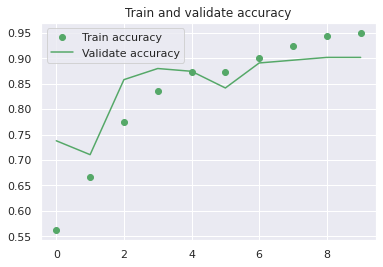

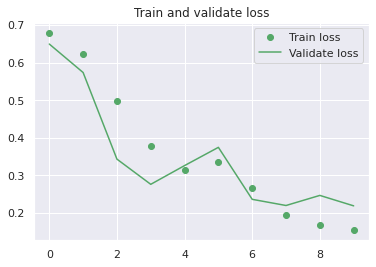

In [ ]:
acc = history_lstm1.history['acc']                        
val_acc = history_lstm1.history['val_acc']
loss = history_lstm1.history['loss']
val_loss = history_lstm1.history['val_loss']
plt.plot( acc, 'go', label='Train accuracy')
plt.plot( val_acc, 'g', label='Validate accuracy')
plt.title('Train and validate accuracy')
plt.legend()                                           

plt.figure()
plt.plot( loss, 'go', label='Train loss')
plt.plot( val_loss, 'g', label='Validate loss')
plt.title('Train and validate loss')
plt.legend()
plt.show()

In [ ]:
# Load tokenizer object
with open('/content/tokenizer.pickle', 'rb') as handle:
    tokenizers = pickle.load(handle)

model = load_model('/content/lastm-1-layer-best_model.h5')
#model.save('/content/drive/MyDrive/Colab_Notebooks/DL Model/Twitter Suicide Ideation Detection/lstm 1-layer.h5') 

twt = ['i will not kill myself ']
twt = tokenizers.texts_to_sequences(twt)
twt = pad_sequences(twt, maxlen=60, dtype='int32')

predicted = model.predict(twt,batch_size=1,verbose = True)
if(np.argmax(predicted) == 0):
    print("Potential Suicide Post")
elif (np.argmax(predicted) == 1):
    print("Non Suicide Post")

1/1 [==============================] - 1s 770ms/step
Non Suicide Post


## **LSTM 2-Layers**

In [ ]:
epochs = 10
emb_dim = 120                     
batch_size = 50                
model_lstm2 = Sequential()            
model_lstm2.add(Embedding(vocabulary_size,emb_dim ,input_length=X_DeepLearning.shape[1]))
model_lstm2.add(SpatialDropout1D(0.8))
model_lstm2.add(Bidirectional(LSTM(200, dropout=0.5, recurrent_dropout=0.5, return_sequences= True)))
model_lstm2.add(Dropout(0.5))
model_lstm2.add(Bidirectional(LSTM(300, dropout=0.5, recurrent_dropout =0.5)))
model_lstm2.add(Dropout(0.5))
model_lstm2.add(Flatten())
model_lstm2.add(Dense(64, activation='relu'))
model_lstm2.add(Dropout(0.5))
model_lstm2.add(Dense(2, activation='softmax'))
model_lstm2.compile(optimizer=tf.optimizers.Adam(),loss='binary_crossentropy', metrics=['acc']) 
print(model_lstm2.summary())                                                                           

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 60, 120)           720000    
                                                                 
 spatial_dropout1d_28 (Spati  (None, 60, 120)          0         
 alDropout1D)                                                    
                                                                 
 bidirectional_8 (Bidirectio  (None, 60, 400)          513600    
 nal)                                                            
                                                                 
 dropout_59 (Dropout)        (None, 60, 400)           0         
                                                                 
 bidirectional_9 (Bidirectio  (None, 600)              1682400   
 nal)                                                            
                                                     

In [ ]:
checkpoint_callback = ModelCheckpoint(filepath="lastm-2-layer-best_model.h5", save_best_only=True, monitor="val_acc", mode="max", verbose=1)

early_stopping_callback = EarlyStopping(monitor="val_acc", mode="max", patience=10, verbose=1, restore_best_weights=True)

reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

callbacks2=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [ ]:
history_lstm2 = model_lstm2.fit(XX_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=callbacks2)

Epoch 1/10
33/33 [==============================] - ETA: 0s - loss: 0.6810 - acc: 0.5706
Epoch 1: val_acc improved from -inf to 0.67760, saving model to lastm-2-layer-best_model.h5
33/33 [==============================] - 137s 3s/step - loss: 0.6810 - acc: 0.5706 - val_loss: 0.6089 - val_acc: 0.6776 - lr: 0.0010
Epoch 2/10
33/33 [==============================] - ETA: 0s - loss: 0.5828 - acc: 0.7135
Epoch 2: val_acc improved from 0.67760 to 0.80328, saving model to lastm-2-layer-best_model.h5
33/33 [==============================] - 104s 3s/step - loss: 0.5828 - acc: 0.7135 - val_loss: 0.4476 - val_acc: 0.8033 - lr: 0.0010
Epoch 3/10
33/33 [==============================] - ETA: 0s - loss: 0.4545 - acc: 0.8066
Epoch 3: val_acc improved from 0.80328 to 0.84699, saving model to lastm-2-layer-best_model.h5
33/33 [==============================] - 103s 3s/step - loss: 0.4545 - acc: 0.8066 - val_loss: 0.3168 - val_acc: 0.8470 - lr: 0.0010
Epoch 4/10
33/33 [==============================] - 

In [ ]:
results_2 = model_lstm2.evaluate(XX_test, y_test, verbose=False)
print(f'Test results - Loss: {results_2[0]} - Accuracy: {100*results_2[1]}%')

Test results - Loss: 0.19437964260578156 - Accuracy: 91.95402264595032%


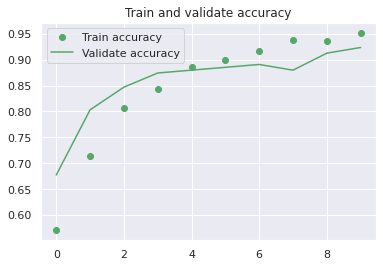

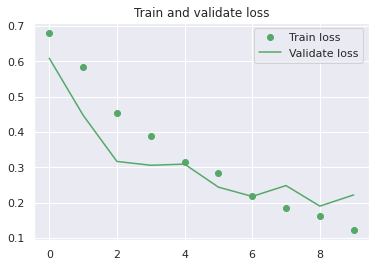

In [ ]:
acc = history_lstm2.history['acc']                          
val_acc = history_lstm2.history['val_acc']
loss = history_lstm2.history['loss']
val_loss = history_lstm2.history['val_loss']

plt.plot( acc, 'go', label='Train accuracy')
plt.plot( val_acc, 'g', label='Validate accuracy')
plt.title('Train and validate accuracy')
plt.legend()                                            

plt.figure()

plt.plot( loss, 'go', label='Train loss')
plt.plot( val_loss, 'g', label='Validate loss')
plt.title('Train and validate loss')
plt.legend()

plt.show() 

In [ ]:
# Load tokenizer object
with open('/content/tokenizer.pickle', 'rb') as handle:
    tokenizers = pickle.load(handle)

model = load_model('/content/lastm-2-layer-best_model.h5')
#model.save('/content/drive/MyDrive/Colab_Notebooks/DL Model/Twitter Suicide Ideation Detection/lstm 2-layer.h5') 

twt = ["i will not kill myself. "]
twt = tokenizers.texts_to_sequences(twt)
twt = pad_sequences(twt, maxlen=60, dtype='int32')

predicted = model.predict(twt,batch_size=1,verbose = True)
if(np.argmax(predicted) == 0):
    print("Potential Suicide Post")
elif (np.argmax(predicted) == 1):
    print("Non Suicide Post")

1/1 [==============================] - 2s 2s/step
Non Suicide Post


## **GRU**

In [ ]:
epochs = 10
emb_dim = 120                     
batch_size = 50                
model_gru = Sequential()            
model_gru.add(Embedding(vocabulary_size,emb_dim ,input_length=X_DeepLearning.shape[1]))
model_gru.add(SpatialDropout1D(0.5))
model_gru.add(GRU(units=16,  dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01)))
model_gru.add(Dropout(0.5))
model_gru.add(Dense(228, activation='relu', kernel_regularizer=l2(0.01)))
model_gru.add(Dropout(0.5))
model_gru.add(Dense(2, activation='softmax'))
model_gru.compile(optimizer=tf.optimizers.Adam(),loss='binary_crossentropy', metrics=['acc']) 
print(model_gru.summary())                                                                           

Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_73 (Embedding)    (None, 60, 120)           720000    
                                                                 
 spatial_dropout1d_66 (Spati  (None, 60, 120)          0         
 alDropout1D)                                                    
                                                                 
 gru_70 (GRU)                (None, 16)                6624      
                                                                 
 dropout_150 (Dropout)       (None, 16)                0         
                                                                 
 dense_154 (Dense)           (None, 228)               3876      
                                                                 
 dropout_151 (Dropout)       (None, 228)               0         
                                                     

In [ ]:
checkpoint_callback = ModelCheckpoint(filepath="gru-best_model.h5", save_best_only=True, monitor="val_acc", mode="max", verbose=1)

early_stopping_callback = EarlyStopping(monitor="val_acc", mode="max", patience=10, verbose=1, restore_best_weights=True)

reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

callbacks3=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [ ]:
history_gru = model_gru.fit(XX_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1, callbacks=callbacks3)

Epoch 1/10
33/33 [==============================] - ETA: 0s - loss: 1.4599 - acc: 0.5608
Epoch 1: val_acc improved from -inf to 0.62842, saving model to gru-best_model.h5
33/33 [==============================] - 7s 94ms/step - loss: 1.4599 - acc: 0.5608 - val_loss: 1.2332 - val_acc: 0.6284 - lr: 0.0010
Epoch 2/10
33/33 [==============================] - ETA: 0s - loss: 1.0969 - acc: 0.5620
Epoch 2: val_acc did not improve from 0.62842
33/33 [==============================] - 3s 80ms/step - loss: 1.0969 - acc: 0.5620 - val_loss: 0.9477 - val_acc: 0.6284 - lr: 0.0010
Epoch 3/10
33/33 [==============================] - ETA: 0s - loss: 0.8485 - acc: 0.6405
Epoch 3: val_acc improved from 0.62842 to 0.80328, saving model to gru-best_model.h5
33/33 [==============================] - 3s 80ms/step - loss: 0.8485 - acc: 0.6405 - val_loss: 0.6723 - val_acc: 0.8033 - lr: 0.0010
Epoch 4/10
33/33 [==============================] - ETA: 0s - loss: 0.5619 - acc: 0.8595
Epoch 4: val_acc improved from 0

In [ ]:
results_3 = model_gru.evaluate(XX_test, y_test, verbose=False)
print(f'Test results - Loss: {results_3[0]} - Accuracy: {100*results_3[1]}%')

Test results - Loss: 0.25998175144195557 - Accuracy: 91.46141409873962%


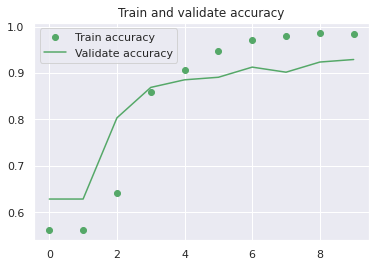

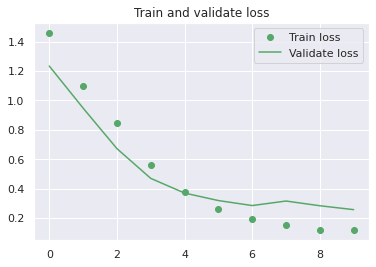

In [ ]:
acc = history_gru.history['acc']                          
val_acc = history_gru.history['val_acc']
loss = history_gru.history['loss']
val_loss = history_gru.history['val_loss']

plt.plot( acc, 'go', label='Train accuracy')
plt.plot( val_acc, 'g', label='Validate accuracy')
plt.title('Train and validate accuracy')
plt.legend()                                            

plt.figure()

plt.plot( loss, 'go', label='Train loss')
plt.plot( val_loss, 'g', label='Validate loss')
plt.title('Train and validate loss')
plt.legend()

plt.show() 

In [ ]:
# Load tokenizer object
with open('/content/tokenizer.pickle', 'rb') as handle:
    tokenizers = pickle.load(handle)

model = load_model('/content/gru-best_model.h5')
#model.save('/content/drive/MyDrive/Colab_Notebooks/DL Model/Twitter Suicide Ideation Detection/gru-best_model.h5') 

twt = ["i will not kill myself."]
twt = tokenizers.texts_to_sequences(twt)
twt = pad_sequences(twt, maxlen=60, dtype='int32')

predicted = model.predict(twt,batch_size=1,verbose = True)
if(np.argmax(predicted) == 0):
    print("Potential Suicide Post")
elif (np.argmax(predicted) == 1):
    print("Non Suicide Post")

1/1 [==============================] - 1s 938ms/step
Non Suicide Post


## **CNN+LSTM**

In [ ]:
epochs = 10
emb_dim = 120                                                                
batch_size = 50
model_cl = Sequential()
model_cl.add(Embedding(vocabulary_size,emb_dim, input_length=X_DeepLearning.shape[1]))
model_cl.add(SpatialDropout1D(0.8))
model_cl.add(Conv1D(filters=64, kernel_size=6, padding='same', activation='relu'))
model_cl.add(MaxPooling1D(pool_size=2))
model_cl.add(Conv1D(filters=32, kernel_size=6, activation='relu'))
model_cl.add(MaxPooling1D(pool_size=2))
model_cl.add(Bidirectional(LSTM(100, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)))
model_cl.add(Dropout(0.5))
model_cl.add(Bidirectional(LSTM(400, dropout=0.5, recurrent_dropout=0.5)))
model_cl.add(Dropout(0.5))
model_cl.add(Flatten())
model_cl.add(Dense(64, activation='relu'))
model_cl.add(Dropout(0.5))
model_cl.add(Dense(2, activation='softmax'))
model_cl.compile(optimizer='adam',loss='binary_crossentropy', metrics=['acc'])
print(model_cl.summary())                                                                           

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 60, 120)           720000    
                                                                 
 spatial_dropout1d_27 (Spati  (None, 60, 120)          0         
 alDropout1D)                                                    
                                                                 
 conv1d_4 (Conv1D)           (None, 60, 64)            46144     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 30, 64)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 25, 32)            12320     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 12, 32)         

In [ ]:
checkpoint_callback = ModelCheckpoint(filepath="cnn+lastm-best_model.h5", save_best_only=True, monitor="val_acc", mode="max", verbose=1)

early_stopping_callback = EarlyStopping(monitor="val_acc", mode="max", patience=10, verbose=1, restore_best_weights=True)

reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [ ]:
history_cl = model_cl.fit(XX_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1, callbacks=callbacks)

Epoch 1/10
33/33 [==============================] - ETA: 0s - loss: 0.6878 - acc: 0.5481
Epoch 1: val_acc improved from -inf to 0.67760, saving model to cnn+lastm-best_model.h5
33/33 [==============================] - 34s 701ms/step - loss: 0.6878 - acc: 0.5481 - val_loss: 0.6495 - val_acc: 0.6776 - lr: 0.0010
Epoch 2/10
33/33 [==============================] - ETA: 0s - loss: 0.6253 - acc: 0.6679
Epoch 2: val_acc improved from 0.67760 to 0.69399, saving model to cnn+lastm-best_model.h5
33/33 [==============================] - 21s 653ms/step - loss: 0.6253 - acc: 0.6679 - val_loss: 0.5888 - val_acc: 0.6940 - lr: 0.0010
Epoch 3/10
33/33 [==============================] - ETA: 0s - loss: 0.5660 - acc: 0.7135
Epoch 3: val_acc improved from 0.69399 to 0.78689, saving model to cnn+lastm-best_model.h5
33/33 [==============================] - 22s 657ms/step - loss: 0.5660 - acc: 0.7135 - val_loss: 0.4585 - val_acc: 0.7869 - lr: 0.0010
Epoch 4/10
33/33 [==============================] - ETA: 0

In [ ]:
results_4 = model_cl.evaluate(XX_test, y_test, verbose=False)
print(f'Test results - Loss: {results_4[0]} - Accuracy: {100*results_4[1]}%')

Test results - Loss: 0.19563108682632446 - Accuracy: 93.92446875572205%


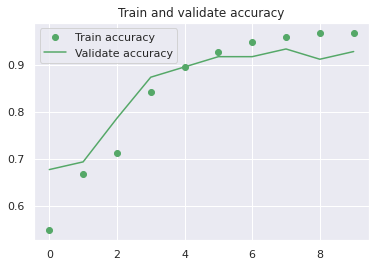

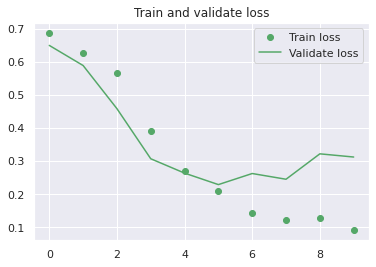

In [ ]:
acc = history_cl.history['acc']                          
val_acc = history_cl.history['val_acc']
loss = history_cl.history['loss']
val_loss = history_cl.history['val_loss']
plt.plot( acc, 'go', label='Train accuracy')
plt.plot( val_acc, 'g', label='Validate accuracy')
plt.title('Train and validate accuracy')
plt.legend()                                           

plt.figure()
plt.plot( loss, 'go', label='Train loss')
plt.plot( val_loss, 'g', label='Validate loss')
plt.title('Train and validate loss')
plt.legend()
plt.show() 

In [ ]:
# Load tokenizer object
with open('tokenizer.pickle', 'rb') as handle:
    tokenizers = pickle.load(handle)
    
model = load_model('/content/cnn+lastm-best_model.h5')
model_cl.save('/content/drive/MyDrive/Colab_Notebooks/DL Model/Twitter Suicide Ideation Detection/CNN+LSTM.h5') 

twt = ['I will not kill myself']
twt = tokenizer.texts_to_sequences(twt)
twt = pad_sequences(twt, maxlen=60, dtype='int32')

predicted = model.predict(twt,batch_size=1,verbose = True)
if(np.argmax(predicted) == 0):
    print("Potential Suicide Post")
elif (np.argmax(predicted) == 1):
    print("Non Suicide Post")

1/1 [==============================] - 1s 1s/step
Non Suicide Post


## **Model Comparision**

In [ ]:
results=pd.DataFrame({'Model':['LSTM-1 Layer','LSTM-2 Layer','GRU','CNN+LSTM'],
                     'Accuracy Score':[results_1[1],results_2[1],results_3[1],results_4[1]]})
result_df=results.sort_values(by='Accuracy Score', ascending=False)
result_df=result_df.set_index('Model')
result_df

,Accuracy Score
Model,
CNN+LSTM,0.939245
LSTM-1 Layer,0.919540
LSTM-2 Layer,0.919540
GRU,0.914614


## **Bert Model**

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df['Tweet'], df['Suicide'], test_size=0.33, random_state=42)

In [6]:
X_train = X_train.tolist()
X_test = X_test.tolist()
y_train = y_train.tolist()
y_test = y_test.tolist()

In [7]:
class_names = ['Potential Suicide post', 'Not Suicide post']

In [8]:
(x_train,y_train), (x_val,y_val), preproc = text.texts_from_array(x_train=X_train, y_train=y_train,
                                                                       x_test=X_test, y_test=y_test,
                                                                       class_names=class_names,
                                                                       preprocess_mode='bert',
                                                                       maxlen=140, 
                                                                       max_features=5000)

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


/usr/local/lib/python3.9/dist-packages/ktrain/utils.py:744: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  warnings.warn(


task: text classification


In [9]:
model = text.text_classifier('bert', train_data=(x_train,y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 140


/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


done.


In [10]:
learner = ktrain.get_learner(model, train_data=(x_train,y_train), 
                             val_data=(x_val,y_val),
                             batch_size=16)

In [11]:
learner.fit_onecycle(2e-5, 3)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
102/102 [==============================] - 83s 621ms/step - loss: 0.4378 - accuracy: 0.7812 - val_loss: 0.2108 - val_accuracy: 0.9303
Epoch 2/3
102/102 [==============================] - 60s 586ms/step - loss: 0.1508 - accuracy: 0.9485 - val_loss: 0.1243 - val_accuracy: 0.9614
Epoch 3/3
102/102 [==============================] - 58s 568ms/step - loss: 0.0475 - accuracy: 0.9871 - val_loss: 0.1235 - val_accuracy: 0.9639


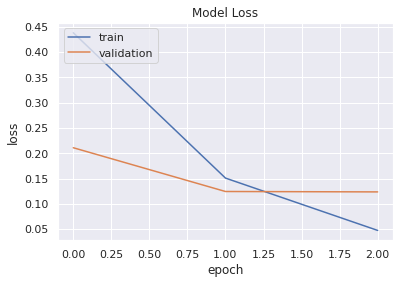

In [12]:
learner.plot()

In [13]:
learner.validate(val_data=(x_val,y_val), class_names=class_names)

26/26 [==============================] - 12s 299ms/step
                        precision    recall  f1-score   support

Potential Suicide post       0.97      0.97      0.97       439
      Not Suicide post       0.96      0.96      0.96       365

              accuracy                           0.96       804
             macro avg       0.96      0.96      0.96       804
          weighted avg       0.96      0.96      0.96       804



array([[425,  14],
       [ 15, 350]])

In [14]:
predictor = ktrain.get_predictor(learner.model, preproc)
predictor.get_classes()

['Not Suicide post', 'Potential Suicide post']

In [15]:
message = 'i will not kill myself'
prediction = predictor.predict(message)
print('predicted: {}'.format(prediction))

1/1 [==============================] - 0s 48ms/step
predicted: Not Suicide post


**Save Bert Model**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
predictor.save("/content/drive/MyDrive/Colab_Notebooks/DL Model/Twitter Suicide Ideation Detection/bert_model_Suicide")

**Load Saved Model and Predict**

In [ ]:
predictor1 = ktrain.load_predictor('/content/drive/MyDrive/Colab_Notebooks/DL Model/Twitter Suicide Ideation Detection/bert_model_Suicide')

In [1]:
data = "I'm very happy"
predictor1.predict(data)

NameError: name 'predictor1' is not defined